## Plotting with Circos plots
### note that the way the sv_for_plot.tsv was created is:

bcftools isec -c none -n -1 -w1 -O v \
-o tumor_only.vcf.gz \
~/my_lustre/sawfish-tumor-all/tumor-all_pbmm2-farm22_joint_call/genotyped.sv.vcf.gz \
~/my_lustre/sawfish/1B02genotyped.sv.vcf.gz

### had to reheader the sample from unnamed to TUMOR

### Index the outputs in between steps
tabix -p vcf tumor_only.vcf.gz

###  Keep only large structural variants (SVLEN ≥ 1000) - this removed all
bcftools filter -i 'INFO/SVLEN>=1000' tumor_somatic.vcf.gz -O v -o tumor_large_svs.vcf.gz

### possible to visualize in a way - in the end in Python
bcftools query -f '%CHROM\t%POS\t%SVTYPE\t%MATEID\n' tumor_large_svs.vcf.gz > sv_for_plot.tsv

In [14]:
import sys
print(sys.executable)

/home/jovyan/my-conda-envs/my-python/bin/python


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import pycircos
import matplotlib.pyplot as plt # plots
import scipy.sparse as sp
from scipy.sparse import csr_matrix # matrices
import sys # system
import os # system
import glob # global system
from os import listdir
from os.path import isfile, join
import pycircos
import matplotlib.pyplot as plt
import sys
import os
import pycircos
import collections
import matplotlib
import math
# as the python package is too many, 
from pycircos.pycircos import Garc
from pycircos.pycircos import Gcircle 

In [1]:
# set base directory
base_dir = "/lustre/scratch126/casm/team274sb/lr26/"

In [6]:
import pandas as pd

# Define the data for T2T chromosomes (from the vcf header)
data = [
    ("chr1", 1, 248387328),
    ("chr2", 1, 242696752),
    ("chr3", 1, 201105948),
    ("chr4", 1, 193574945),
    ("chr5", 1, 182045439),
    ("chr6", 1, 172126628),
    ("chr7", 1, 160567428),
    ("chr8", 1, 146259331),
    ("chr9", 1, 150617247),
    ("chr10", 1, 134758134),
    ("chr11", 1, 135127769),
    ("chr12", 1, 133324548),
    ("chr13", 1, 113566686),
    ("chr14", 1, 101161492),
    ("chr15", 1, 99753195),
    ("chr16", 1, 96330374),
    ("chr17", 1, 84276897),
    ("chr18", 1, 80542538),
    ("chr19", 1, 61707364),
    ("chr20", 1, 66210255),
    ("chr21", 1, 45090682),
    ("chr22", 1, 51324926),
    ("chrX", 1, 154259566),
    ("chrY", 1, 62460029),
    ("chrM", 1, 16569)
]

# Create DataFrame
df = pd.DataFrame(data, columns=["Chromosome", "Start", "End"])

# Display the DataFrame
print(df)

df.to_csv(base_dir + "chromosome_data.csv", index=False)



   Chromosome  Start        End
0        chr1      1  248387328
1        chr2      1  242696752
2        chr3      1  201105948
3        chr4      1  193574945
4        chr5      1  182045439
5        chr6      1  172126628
6        chr7      1  160567428
7        chr8      1  146259331
8        chr9      1  150617247
9       chr10      1  134758134
10      chr11      1  135127769
11      chr12      1  133324548
12      chr13      1  113566686
13      chr14      1  101161492
14      chr15      1   99753195
15      chr16      1   96330374
16      chr17      1   84276897
17      chr18      1   80542538
18      chr19      1   61707364
19      chr20      1   66210255
20      chr21      1   45090682
21      chr22      1   51324926
22       chrX      1  154259566
23       chrY      1   62460029
24       chrM      1      16569


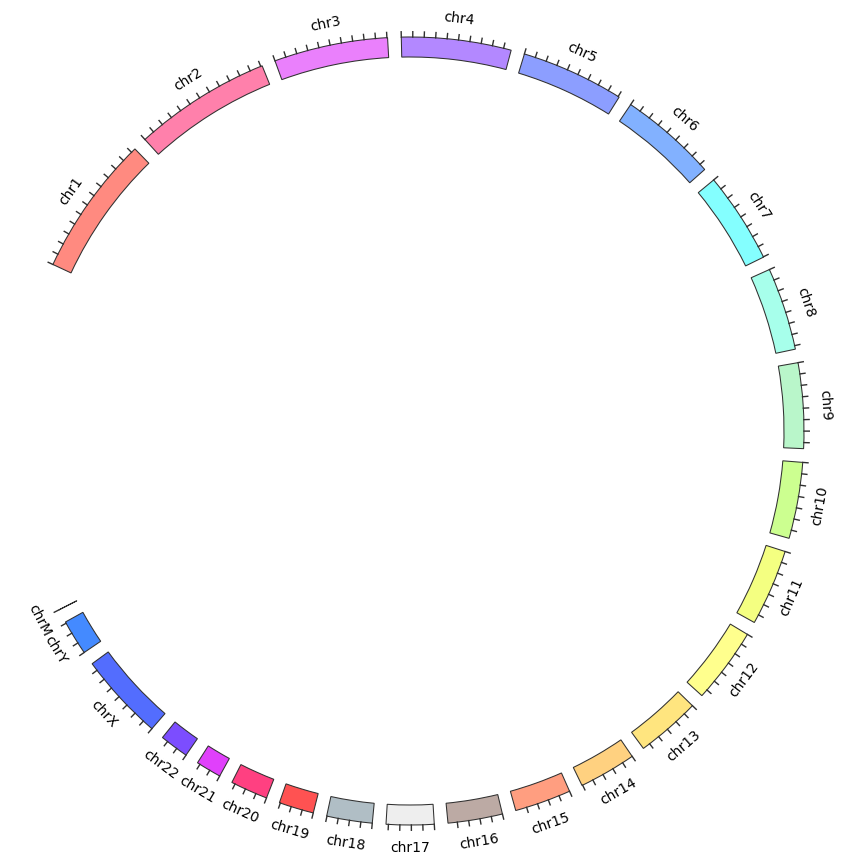

In [7]:
#Set chromosomes
circle = Gcircle(figsize=(8,8)) 
with open(base_dir + "chromosome_data.csv") as f:
    f.readline()
    for line in f:
        line   = line.rstrip().split(",") 
        name   = line[0]
        length = int(line[-1]) 
        arc    = Garc(arc_id=name, size=length, interspace=2, raxis_range=(935,985), labelposition=80, label_visible=True)
        circle.add_garc(arc) 
        
circle.set_garcs(-65,245) # can be 180 degrees from both sides

for arc_id in circle.garc_dict:
    circle.tickplot(arc_id, raxis_range=(985,1000), tickinterval=20000000, ticklabels=None) 

In [17]:
import pandas as pd
import re

# Load VCF file, skipping comment lines
vcf_file = (base_dir + "sawfish/annotated_tumor_without_bloods.vcf")

col_names = ["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT", "UnnamedSample"]

df = pd.read_csv(vcf_file, comment='#', sep='\t', names=col_names)

print(df.columns)

print(df)

Index(['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'UnnamedSample'],
      dtype='object')
     #CHROM       POS                     ID  \
0      chr1      3293        sawfish:0:1:0:0   
1      chr1      3634        sawfish:0:1:1:0   
2      chr1      4728        sawfish:0:2:0:0   
3      chr1     24437        sawfish:0:5:0:0   
4      chr1     29292        sawfish:0:7:0:1   
...     ...       ...                    ...   
9704   chrY   5204851    sawfish:0:66602:0:0   
9705   chrY  62189891    sawfish:0:66607:0:0   
9706   chrM      6507  sawfish:0:25340:0:0:1   
9707   chrM      7974  sawfish:0:25342:0:0:1   
9708   chrM     16051  sawfish:0:37522:0:0:1   

                                                    REF  \
0                                                     G   
1     GCCCTCTTGCTCACAGTGTAGTGGCAGCACGCCCGCCTGCTGGCAG...   
2     TCACACAACTAATCACTCAAAATCATCCTTACACTAAAAATGCTAA...   
3     ATCTCAGCAGCTCACGGTGTAGAAACTGCGACACTCACATGGGTGC...   
4

In [125]:
# filtering - from 731 BND vars to 190 - question whether not to annotate first
df_filtered = df[df["QUAL"] > 800]
df_filtered
df_filt = df_filtered[df_filtered["FILTER"] == "PASS"]
df_filt
df_filt['HOMLEN'] = df_filt['INFO'].str.extract(r'HOMLEN=(\d+)', expand=False).fillna(0).astype(int)
# Filter out rows where HOMLEN >= 20
df_hm = df_filt[df_filt['HOMLEN'] < 5].drop(columns=['HOMLEN'])  # Drop HOMLEN if not needed
# Print results
print(df_hm)

    #CHROM        POS                     ID REF                ALT  QUAL  \
1     chr1    8595278    sawfish:0:351:0:0:0   C  C]chr14:87478740]   999   
2     chr1    8595284    sawfish:0:353:0:0:0   C  [chr14:87478050[C   999   
3     chr1   26640838    sawfish:0:660:0:0:0   T  [chr1:111368225[T   999   
9     chr1   75219503   sawfish:0:1182:0:0:0   T  ]chr22:19322350]T   999   
10    chr1   75220025   sawfish:0:1180:0:0:0   G  G[chr22:19314661[   999   
..     ...        ...                    ...  ..                ...   ...   
696  chr22   19322350   sawfish:0:1182:0:0:1   T   T[chr1:75219503[   999   
698  chr22   24300932  sawfish:0:35671:0:0:1   G  ]chr10:81499682]G   834   
701  chr22   45707167  sawfish:0:26039:0:0:1   A  [chr8:129949845[A   897   
716   chrX  119567861   sawfish:0:9484:0:0:1   A   A[chr3:89049269[   999   
723   chrX  147444828  sawfish:0:59499:0:0:1   T  T[chr20:45130385[   998   

    FILTER                                               INFO       FORMAT 

/tmp/ipykernel_2373/2993658969.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['HOMLEN'] = df_filt['INFO'].str.extract(r'HOMLEN=(\d+)', expand=False).fillna(0).astype(int)


In [11]:
print(df.columns)  # Check actual column names

Index(['0', '1', '2'], dtype='object')


In [91]:
print(df_hm["ALT"])

1      C]chr14:87478740]
2      [chr14:87478050[C
3      [chr1:111368225[T
8      A[chr16:83811131[
9      ]chr22:19322350]T
             ...        
701    [chr8:129949845[A
707    A[chr14:87338206[
716     A[chr3:89049269[
720    [chr12:25495481[T
723    T[chr20:45130385[
Name: ALT, Length: 288, dtype: object


In [92]:
# Convert to DataFrame
df_hmm = pd.DataFrame(df_hm)

print(df_hmm.head())  # Check the structure

  #CHROM       POS                    ID REF                ALT  QUAL FILTER  \
1   chr1   8595278   sawfish:0:351:0:0:0   C  C]chr14:87478740]   999   PASS   
2   chr1   8595284   sawfish:0:353:0:0:0   C  [chr14:87478050[C   999   PASS   
3   chr1  26640838   sawfish:0:660:0:0:0   T  [chr1:111368225[T   999   PASS   
8   chr1  66865158  sawfish:0:1094:0:0:0   A  A[chr16:83811131[   650   PASS   
9   chr1  75219503  sawfish:0:1182:0:0:0   T  ]chr22:19322350]T   999   PASS   

                                                INFO       FORMAT  \
1  SVTYPE=BND;HOMLEN=2;HOMSEQ=TT;MATEID=sawfish:0...  GT:GQ:PL:AD   
2  SVTYPE=BND;HOMLEN=4;HOMSEQ=CCCT;MATEID=sawfish...  GT:GQ:PL:AD   
3              SVTYPE=BND;MATEID=sawfish:0:660:0:0:1  GT:GQ:PL:AD   
8             SVTYPE=BND;MATEID=sawfish:0:1094:0:0:1  GT:GQ:PL:AD   
9  SVTYPE=BND;HOMLEN=3;HOMSEQ=TTT;MATEID=sawfish:...  GT:GQ:PL:AD   

              UnnamedSample  
1   0/1:999:999,0,999:53,45  
2   0/1:999:999,0,999:52,42  
3   0/1:999:99

In [16]:
# put into the format requested by the circos plot

import pandas as pd
import re

def parse_alt(alt):
    match = re.search(r'[\[\]]?([ACGTN]{0,20}?)?(chr[\wXYM]+):(\d+)[ACGTN]{0,20}?[\[\]]?', str(alt))
    if match:
        return match.group(2), int(match.group(3))  # Extract chromosome and position
    return None, None

# Apply the parse_alt function to the ALT column and create new columns for chr2 and start2
df[['chr2', 'start2']] = df['ALT'].dropna().apply(lambda alt: pd.Series(parse_alt(alt)))

# Debug: Check after applying function
print("🔍 After ALT Parsing:")
print(df[['ALT', 'chr2', 'start2']].head())

df['end1'] = df['POS'] + 1
df['end2'] = df['start2'] + 1

df = df[['#CHROM', 'POS', 'end1', 'chr2', 'start2', 'end2']].rename(
    columns={'#CHROM': 'chr1', 'POS': 'start1'}
)

# Debug: Check final DataFrame
print("🔍 Final DataFrame:")
print(df.head())

# Save to file
df.to_csv(base_dir + "filtered_tumor_somatic_bnd_ready_plotting.tsv", sep="\t", index=False)
df.to_csv(base_dir + "filtered_tumor_somatic_bnd_ready_plotting.csv", sep=",", index=False)

print("✅ Successfully processed data!")

KeyError: 'ALT'

In [95]:
df_f

,chr1,start1,end1,chr2,start2,end2
1,chr1,8595278,8595279,chr14,87478740,87478741
2,chr1,8595284,8595285,chr14,87478050,87478051
3,chr1,26640838,26640839,chr1,111368225,111368226
8,chr1,66865158,66865159,chr16,83811131,83811132
9,chr1,75219503,75219504,chr22,19322350,19322351
...,...,...,...,...,...,...
701,chr22,45707167,45707168,chr8,129949845,129949846
707,chrX,66761292,66761293,chr14,87338206,87338207
716,chrX,119567861,119567862,chr3,89049269,89049270
720,chrX,145918372,145918373,chr12,25495481,25495482


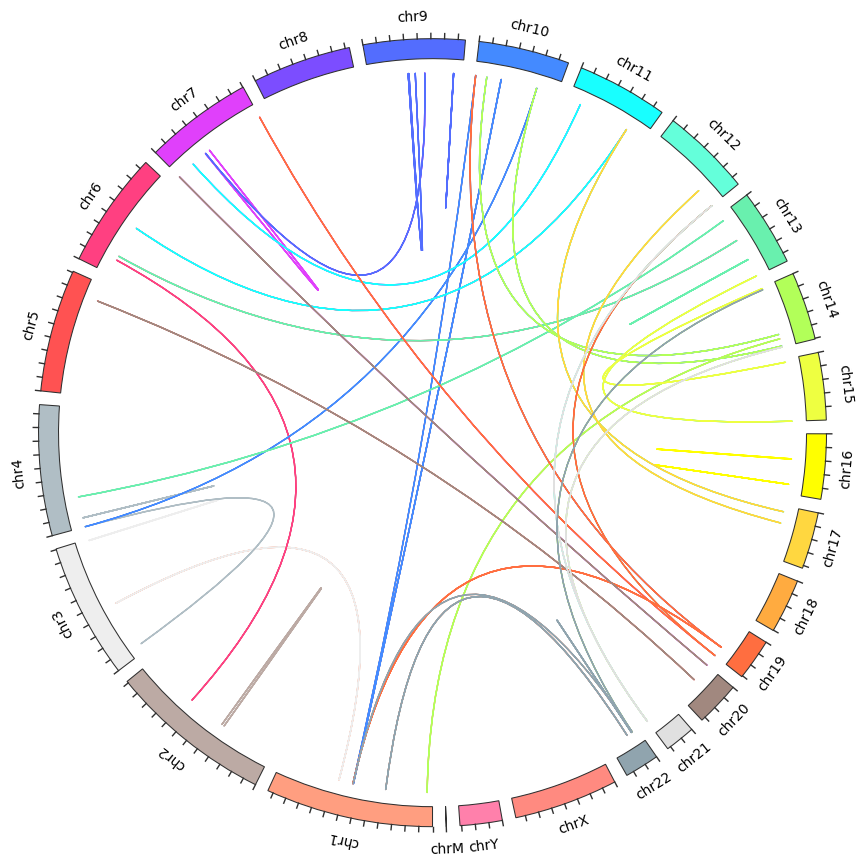

In [19]:
#Set chromosomes
circle = Gcircle(figsize=(8,8)) 
with open(base_dir + "/chromosome_data.csv") as f:
    f.readline()
    for line in f:
        line   = line.rstrip().split(",") 
        name   = line[0]
        length = int(line[-1]) 
        arc    = Garc(arc_id=name, size=length, interspace=2, raxis_range=(935,985), labelposition=80, label_visible=True)
        circle.add_garc(arc) 
        
circle.set_garcs(-180, 180)  # Ensure full circle

for arc_id in circle.garc_dict:
    circle.tickplot(arc_id, raxis_range=(985,1000), tickinterval=20000000, ticklabels=None)

with open(base_dir + "/filtered_tumor_somatic_bnd_ready_plotting.csv") as f:
    next(f)  # Skip header line
    for line in f:
        line = line.rstrip().split(",")
        name1, start1, end1 = line[0], int(line[1]), int(line[2])
        name2, start2, end2 = line[3], int(line[4]), int(line[5])

        # Get facecolors from the arc dictionary
        facecolor1 = circle.garc_dict[name1].facecolor if name1 in circle.garc_dict else "gray"
        facecolor2 = circle.garc_dict[name2].facecolor if name2 in circle.garc_dict else "gray"

        # Draw the chord
        source = (name1, start1, end1, 900)
        destination = (name2, start2, end2, 900)
        circle.chord_plot(source, destination, facecolor=facecolor1, edgecolor=facecolor1, linewidth=1)


In [20]:
circle.figure.savefig(base_dir + "/sawfish_bndvars_tum_filtered_new.pdf", dpi=300, bbox_inches="tight")

New criteria: took the tumor vcf and subtracted everything that was shared with mother and matched normal. Then I also filtered according to: 

(ensuring everything indexed) 

bcftools isec -n=1 -w1 -o tumor_somatic.sv.vcf.gz tumorgenotyped.sv.vcf.gz 1C01genotyped.sv.vcf.gz 1B02genotyped.sv.vcf.gz

bcftools view -i 'SVTYPE="BND" & FILTER="PASS" & HOMLEN<=5 & QUAL>500' tumor_somatic.sv.vcf > filtered_tumor_somatic_bnd.vcf



In [8]:
import pandas as pd

import pandas as pd

# Load all three files
file1 = pd.read_csv("/lustre/scratch126/casm/team274sb/lr26/nanomonsv-new-patient-data/output/tumor-all/filtered_tumor_somatic_bnd_nanomon_plotting.csv",
                     sep=",", header=None, 
                     names=["chr1", "start1", "end1", "chr2", "start2", "end2"])
file2 = pd.read_csv("/lustre/scratch126/casm/team274sb/lr26/sawfish/filtered_tumor_somatic_bnd_ready_plotting.csv",
                     sep=",", header=None, 
                     names=["chr1", "start1", "end1", "chr2", "start2", "end2"])
file3 = pd.read_csv("/lustre/scratch126/casm/team274sb/lr26/severus-results/tumor_somatic_breakpoints_ready_for_plotting.csv",
                     sep=",", header=None, 
                     names=["chr1", "start1", "end1", "chr2", "start2", "end2"])

# Ensure numeric columns are integers
for df in [file1, file2, file3]:
    df["start1"] = pd.to_numeric(df["start1"], errors="coerce")
    df["end1"] = pd.to_numeric(df["end1"], errors="coerce")

# Drop rows with NaN (caused by conversion errors)
for df in [file1, file2, file3]:
    df.dropna(subset=["start1", "end1"], inplace=True)

# Sort by chromosome and start position
for df in [file1, file2, file3]:
    df.sort_values(["chr1", "start1"], inplace=True)

# Expand regions by ±50 bp
for df in [file1, file2, file3]:
    df["start1"] = df["start1"] - 50
    df["end1"] = df["end1"] + 50

# **Finding Shared Regions with Interval Overlaps**
# We use a simple interval comparison to retain only overlapping regions

shared_regions = []

for _, row1 in file1.iterrows():
    for _, row2 in file2.iterrows():
        for _, row3 in file3.iterrows():
            if (
                row1["chr1"] == row2["chr1"] == row3["chr1"]  # Same chromosome
                and row1["start1"] <= row2["end1"] and row1["end1"] >= row2["start1"]  # Overlap between file1 and file2
                and row1["start1"] <= row3["end1"] and row1["end1"] >= row3["start1"]  # Overlap between file1 and file3
            ):
                shared_regions.append(row1.tolist())

# Convert to DataFrame
shared_df = pd.DataFrame(shared_regions, columns=file1.columns).drop_duplicates()

# Save the shared regions to a new file
shared_df.to_csv("/lustre/scratch126/casm/team274sb/lr26/shared_regions.tsv", sep="\t", index=False)

print("Filtered shared regions saved as 'shared_regions.tsv'.")


Filtered shared regions saved as 'shared_regions.tsv'.


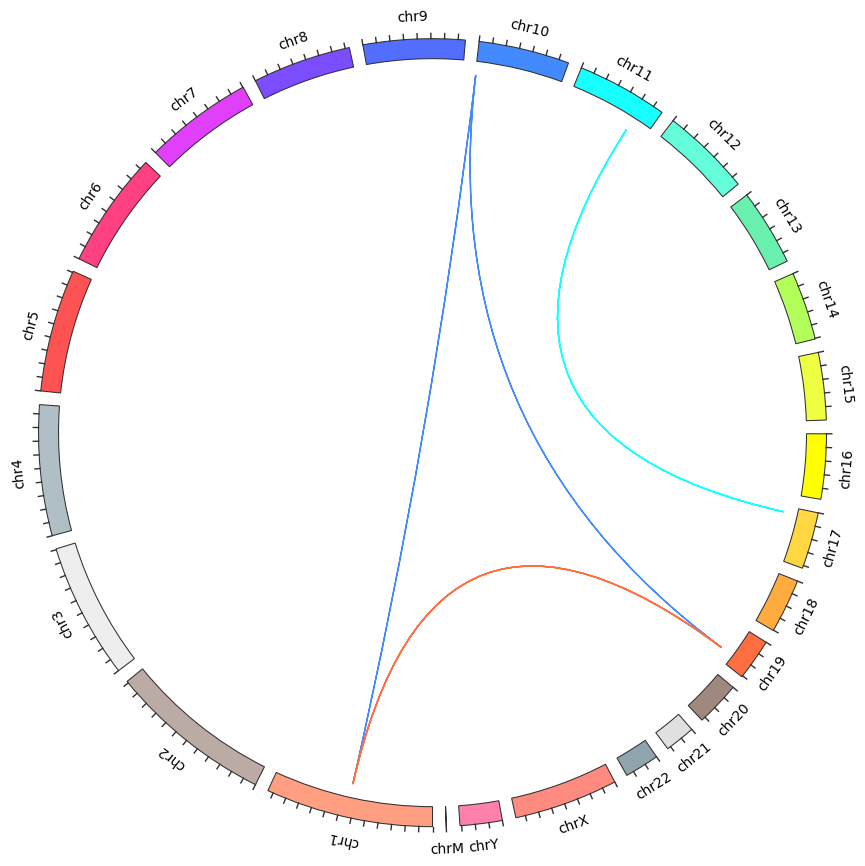

In [12]:
#Set chromosomes
circle = Gcircle(figsize=(8,8)) 
with open("/lustre/scratch126/casm/team274sb/lr26/severus-results/chromosome_data.csv") as f:
    f.readline()
    for line in f:
        line   = line.rstrip().split(",") 
        name   = line[0]
        length = int(line[-1]) 
        arc    = Garc(arc_id=name, size=length, interspace=2, raxis_range=(935,985), labelposition=80, label_visible=True)
        circle.add_garc(arc) 
        
circle.set_garcs(-180, 180)  # Ensure full circle

for arc_id in circle.garc_dict:
    circle.tickplot(arc_id, raxis_range=(985,1000), tickinterval=20000000, ticklabels=None)

with open("/lustre/scratch126/casm/team274sb/lr26/shared_regions.tsv") as f:
    next(f)  # Skip header line
    for line in f:
        line = line.rstrip().split("\t")

        # Define name1, start1, end1
        name1, start1, end1 = line[0], int(float(line[1])), int(float(line[2]))
        name2, start2, end2 = line[3], int(float(line[4])), int(float(line[5]))
        
        facecolor1 = circle.garc_dict[name1].facecolor if name1 in circle.garc_dict else "gray"
        facecolor2 = circle.garc_dict[name2].facecolor if name2 in circle.garc_dict else "gray"

        # Draw the chord
        source = (name1, start1, end1, 900)
        destination = (name2, start2, end2, 900)
        circle.chord_plot(source, destination, facecolor=facecolor1, edgecolor=facecolor1, linewidth=1)

In [13]:
circle.figure.savefig("/lustre/scratch126/casm/team274sb/lr26/shared_regions_nanomon_severus_sawfish.pdf", dpi=300, bbox_inches="tight")

In [ ]:
# i used the sorted_liftoff.gff3 genes and converted them to a T2T_genes_cleaned.bed file 
# and then I used that to annotate my sawfish, severus and nanomonsv vcf files
bcftools annotate -a ../T2T/T2T_genes_cleaned.bed -c CHROM,FROM,TO,INFO/Gene -h <(echo '##INFO=<ID=Gene,Number=1,Type=String,Description="Overlapping gene">') -o annotated_tumor_without_bloods.vcf -O z tumor_without_bloods.vcf
bcftools annotate -a ~/my_lustre/T2T/T2T_genes_cleaned.bed -c CHROM,FROM,TO,INFO/Gene -h <(echo '##INFO=<ID=Gene,Number=1,Type=String,Description="Overlapping gene">') -o annotated_tumor_nanomonsv_sv.vcf -O z tumor_all.nanomonsv.results.vcf
bcftools annotate -a ~/my_lustre/T2T/T2T_genes_cleaned.bed -c CHROM,FROM,TO,INFO/Gene -h <(echo '##INFO=<ID=Gene,Number=1,Type=String,Description="Overlapping gene">') -o annotated_tumor_somatic_breakpoints_sv.vcf -O z tumor_somatic_breakpoints_double.sorted.vcf.gz